In [1]:
import pickle
import re
import sys
from datetime import date, datetime, timedelta
from importlib import reload
from pathlib import Path

import get_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import talib
import yfinance as yf
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from tools import inspect_code, plotting, training, wandb_api
from tools.training import Datapoint
from tqdm import tqdm
from wandb.keras import WandbCallback

import utils
import wandb

repo_path = Path().resolve().parent
log_wandb = True


2022-05-05 00:24:47.722062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 00:24:47.722127: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [176]:
wandb_api.login()
api = wandb.Api()
run_name = "ok1clej9"
run = api.run(f"matiasetcheverry/crypto-prediction/{run_name}")
config = run.config

root_path = Path("tmp")
model = run.file("rf.pkl")
model = model.download(root=root_path / run.name, replace=True)
with open(model.name, "rb") as file:
    rf = pickle.load(file)
config

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


{'interval': '1d',
 'job_type': 'test',
 'max_depth': 15,
 'n_estimator': 2000,
 'train_val_test_split': [0.8, 0.2, 0.001]}

In [177]:
reload(get_data)
reload(utils)

config["train_val_test_split"] = [0, 0, 1]
df = pd.read_csv(repo_path / "DATE.csv", delimiter=";")
df["beginning_date"] = pd.to_datetime(df.pop("beginning_date"), dayfirst=True, utc=True)
df["ending_date"] = pd.to_datetime(df.pop("ending_date"), dayfirst=True, utc=True)
inputs = [
    {
        "ticker": ticker,
        "beginning_date": datetime.combine(date.today(), datetime.min.time()) - timedelta(days=120),
        "ending_date": datetime.combine(date.today(), datetime.min.time())- timedelta(days=0),
    }
    for ticker in df["ticker"].unique()
    if ticker != "FLOKI"
]

dm = utils.DataModule(
    config=config,
    compute_metrics=utils._concatenate_indicators,
    inputs=inputs,
)
dm.setup()
test_datapoints = dm.test_datapoints

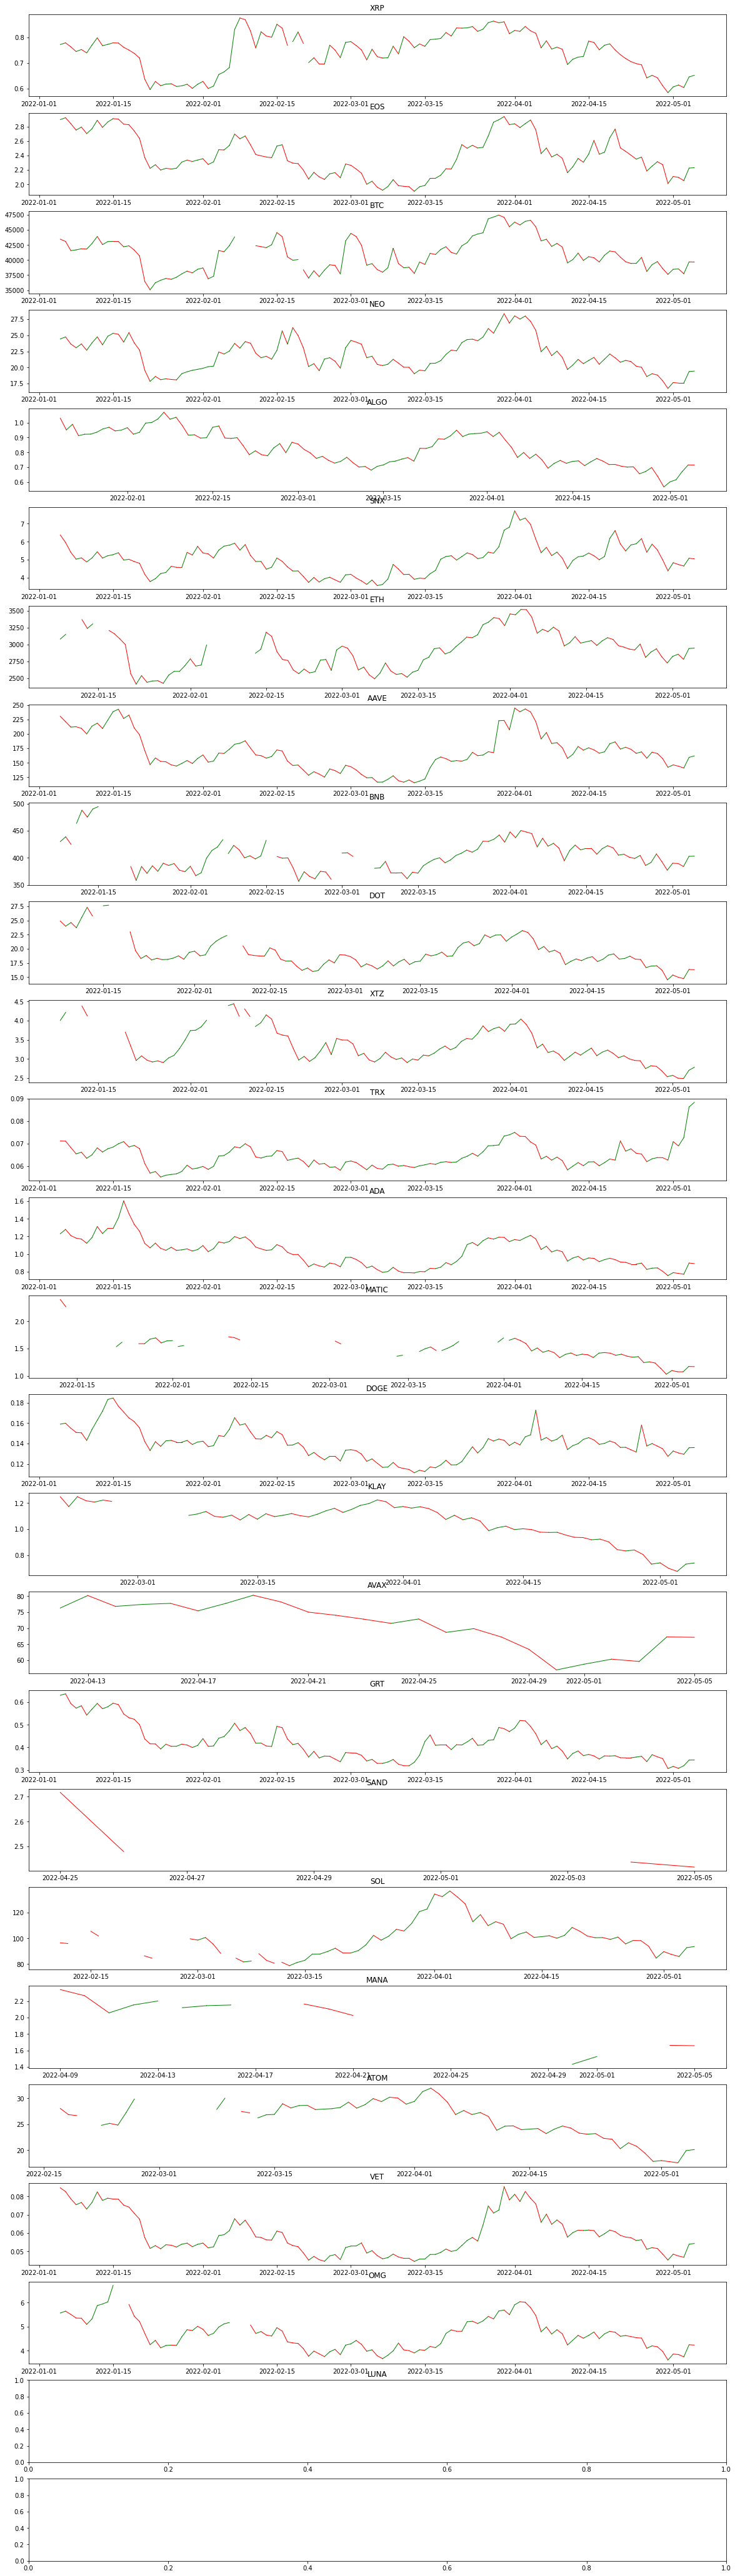

In [178]:
m = len(test_datapoints)
plot = True

if plot:
    fig, axs = plt.subplots(m + 1, figsize=(20, 3 * m))

for index, dp in enumerate(test_datapoints[:m]):
    last_n_points = 0

    proba = dp.predict_proba_from(rf)[-last_n_points:]
    predictions = proba > 0.5
    # print(dp.ticker, np.max(predictions))
    labels = dp.labels[-last_n_points:]
    df = dp.df[-last_n_points:]

    test_datapoints[index].recall = recall_score(
        labels,
        predictions.reshape(-1, 1),
    )
    test_datapoints[index].precision = precision_score(
        labels,
        predictions.reshape(-1, 1),
        zero_division=0,
    )
    test_datapoints[index].accuracy = accuracy_score(
        labels,
        predictions.reshape(-1, 1),
    )

    if plot:
        close_idx = 3
        # df["Close"].plot(color="black", ax=axs[index])
        color = np.array(["red", "green"])[
            ((df["Open"] < df["Close"]).astype(np.int32).to_numpy())
        ]

        for idx, up in enumerate(predictions):
            if up and idx > 0:
                axs[index].plot(
                    df.index[idx - 1 : idx + 1],
                    df["Close"][idx - 1 : idx + 1],
                    color=color[idx],
                    linewidth=1,
                )
        axs[index].set_title(dp.ticker)
plt.show()


In [179]:
for dp in test_datapoints:
    if dp.ticker in ["ETH", "BTC", "BNB", "LTC", "XRP", "TRX"]:
        print(dp.ticker, dp.predict_proba_last_from(rf))


XRP 0.528
BTC 0.532
ETH 0.5305
BNB 0.5215
TRX 0.555


In [181]:
test_datapoints.sort(key=lambda x: x.precision, reverse=True)
for dp in test_datapoints:
    print(dp.ticker, "\t", dp.precision, "\t", dp.recall)


ALGO 	 0.5673076923076923 	 0.9076923076923077
TRX 	 0.5619834710743802 	 1.0
DOT 	 0.5412844036697247 	 0.9672131147540983
ETH 	 0.5392156862745098 	 0.873015873015873
BNB 	 0.5346534653465347 	 0.9
ATOM 	 0.5245901639344263 	 0.5614035087719298
BTC 	 0.5172413793103449 	 0.967741935483871
SNX 	 0.512396694214876 	 1.0
XTZ 	 0.504950495049505 	 0.864406779661017
MANA 	 0.5 	 0.08928571428571429
NEO 	 0.49586776859504134 	 1.0
SOL 	 0.49230769230769234 	 0.5333333333333333
MATIC 	 0.49056603773584906 	 0.4727272727272727
EOS 	 0.4793388429752066 	 1.0
DOGE 	 0.4793388429752066 	 1.0
XRP 	 0.4789915966386555 	 0.9827586206896551
AAVE 	 0.47107438016528924 	 1.0
OMG 	 0.4649122807017544 	 0.9636363636363636
VET 	 0.4628099173553719 	 1.0
GRT 	 0.4462809917355372 	 1.0
KLAY 	 0.4393939393939394 	 0.9354838709677419
ADA 	 0.4380165289256198 	 1.0
AVAX 	 0.43478260869565216 	 0.1694915254237288
SAND 	 0.0 	 0.0
LUNA 	 0.0 	 0.0


In [155]:
for dpi in test_datapoints:
    if dpi.ticker == "SOL":
        dp = dpi
dp

In [76]:
import vectorbt as vbt

reload(get_data)
from datetime import datetime, timedelta
import vectorbt as vbt

vbt.settings.portfolio["fees"] = 0.001
vbt.settings.portfolio["slippage"] = 0.0025
data = vbt.Data.from_data(
    {dp.ticker: dp.df.drop(labels="Direction", axis=1) for dp in dm.test_datapoints},
    download_kwargs={},
)


/home/matias/.pyenv/versions/3.9.8/envs/binance/lib/python3.9/site-packages/vectorbt/data/base.py:527: UserWarning:

Symbols have mismatching index. Setting missing data points to NaN.



In [81]:
def apply_rf(*args, **kwargs):
    proba = kwargs["proba"]
    price = np.squeeze(np.stack(args[1:], axis=1))
    length = price.shape[0]
    try:
        probabilities = rf.predict_proba(price)
        direction = np.argmax(probabilities > proba, axis=1)
    except ValueError:
        direction = np.zeros(length)
    return direction


def plot_trix(trix, signal, column=None, fig=None):
    fig = trix.vbt.plot(fig=fig)
    fig = signal.vbt.plot(fig=fig)


RF = vbt.IndicatorFactory(
    input_names=list(data.data.values())[0].columns[6:],
    output_names=["direction"],
    # subplots=dict(
    #     plot_outputs=dict(
    #         plot_func=plot_trix,
    #         resolve_trix=True,
    #         resolve_signal=True,
    #     )
    # ),
).from_apply_func(
    apply_rf,
    proba=0.5,
)
direction = RF.run(
    *data.get()[6:],
    run_unique=True,
    short_name="entries",
    per_column=True,
    pass_col=True
)
trend_ma = vbt.MA.run(data.get("Close"), window=50, ewm=True, run_unique=True)

ohlcstcx = vbt.OHLCSTCX.run(
    entries=direction.direction_above(0.5),
    open=data.get("Open"),
    high=data.get("High"),
    low=data.get("Low"),
    close=data.get("Close"),
    sl_stop=0.2,
    sl_trail=False,
    tp_stop=0.3,
)

exits = direction.direction.shift(1).astype("bool") | ohlcstcx.exits
entries = direction.direction


In [82]:
pf = vbt.Portfolio.from_signals(
    data.get("Open"),
    entries=entries,
    exits=exits,
    freq=timedelta(days=1),
)
total_return = pf.total_return()
total_return, total_return[total_return != 0].mean(), total_return[
    total_return != 0
].median()
# for idx, p in enumerate(pf):
#     print(p.returns_stats())
# pf.loc[total_return.idxmax()].plot()
# for p in pf:
#     print(p.returns_stats())
#     print("---------------------------------")


(ohlcstcx_sl_stop  ohlcstcx_sl_trail  ohlcstcx_tp_stop  symbol
 0.2               False              0.3               MANA      138.172444
                                                        MATIC      28.934842
                                                        BNB        18.939538
                                                        SNX        43.624088
                                                        XTZ        20.223858
                                                        TRX        13.699306
                                                        NEO        12.397220
                                                        DOGE        4.094612
                                                        VET        15.889708
                                                        ADA        15.831990
                                                        AVAX        0.000000
                                                        EOS        12.117722
             

In [84]:
# for p in pf:
#     print(p.returns_stats())
#     print("---------------------------------")
pf.iloc[2].plots()


FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…